## Slant Edge Algorithm



## Introduction

This notebook presents the Slant Edge algorithm to compute the MTF (Modulation transfer function). It is presented step by step so that an understanding can be gained by reading this notebook.

![](./mtf.jpg)


This diagram shows the MTF for the corresponding slant edge image.

![](./slantedge.png)

The MTF graph was obtained by executing the matlab script srfmat3 written by Peter D. Burns available [here](http://losburns.com/imaging/software/SFRedge/sfrmat3_post/index.html). The python script in this notebook is very much inspired from this code. It looks to be a safe reference to base off of, as the imatest software is also based on it.

The algorithm can be broken down into the following steps:

  1. (not implemented yet) gamma correction
  2. Fit a line on the edge
  3. Compute the average ESF (edge spread function).
  4. Derivate to obtain the LSF (line spread function).
  5. Do a discrete fourier transform. The magitude is the MTF



## Import libraries

The libraries used for the project are:

* **opencv-python** : image processing
* **numpy** : image manipulation/graph manipulation
* **matplotlib** : plotting


In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Load image

A simple cv.imread to read the image. The srfmat3 code includes a ROI selection to able to input a complete resolution chart and only select the slant edge part. This could be added in a future revision.

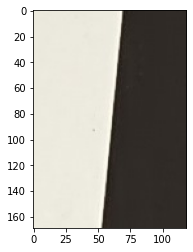

In [4]:
src = cv.imread("slantedge.png")

# OpenCV loads images in BGR while matplotlib
# displays them in RGB. The color component
# need to be reversed here.
plt.imshow(src[:,:,::-1])

**TODO**: It's possible that the slant edge could be in any of the four rotation. Some code need to detect that and rotate the slant edge to have the correct orientation. This is important for the subsequent operations. Here the image is already in the correct orientation but a code to handle the general case would be better here.

## Find edge

It is interesting to see that we could in theory already obtain the ESF (edge spread function) at this point. We just need to select a row of the image. 

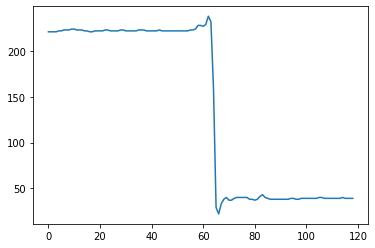

In [7]:
# Here the row 50 and the channel 0 (Blue) is arbitrary selected
plt.plot(src[50, :, 0])

The general idea of the slanted edge is to obtain better precision than that, we will average the ESF of all the rows of the image. But because it is slanted, we cannot just superimpose all the ESF on top of each other. Instead, we need to shift slightly for every next row. So the first goal will be to find the angle of the edge or its slope.

But first, we also have to make the edge more apparent. A common way to do this, is to calculate the first derivative of the image. Here, to show that, we can take the above graph of the ESF, and calculate the 1D gradient.

To obtain the gradient, the cv.filter2D which allows to convolve with any kernel.

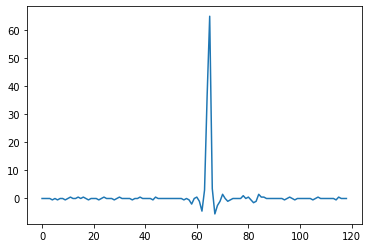

In [16]:
# Here the row 50 and the channel 0 (Blue) is arbitrary selected
lsf = cv.filter2D(np.array([src[50, :, 0]]), cv.CV_64F, np.array([[0.5, -0.5]]))
plt.plot(lsf[0])

A large spike is visible, this is where the edge is because the derivative is large. The same procedure is done row by row but for the entire image. As an example, the input will be the channel 1 (green).

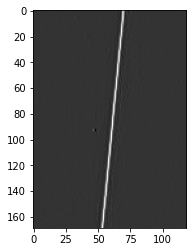

In [18]:
green = src[:,:,1]
result = cv.filter2D(green, cv.CV_64F, np.array([[0.5, -0.5]]))

plt.imshow(result, cmap="gray")

We get a nice image of the edge. The goal now will be to fit a line onto it. This is not entirely straighforward because there is no such function in OpenCV. There is a [fitLine](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gaf849da1fdafa67ee84b1e9a23b93f91f) but to my knowledge this cannot be used to fit onto an image but only a list of points. 

Instead, for **each row**, we will find the centroid (in 1D), also called center of mass in physics, then do a polynomial 1st degree line fitting onto all the centroids found for each row.

Take a row i and let $v_i(j)$ be the pixel value at column j. The centroid $c_i$ for the row i is defined as:

$c_i = \frac{\sum_j v_i(j) \cdot j}{\sum_j v_i(j)}$

Define a list of points $p_i = (i, c_i)$. This is the 2d coordinates points of the centroids for each row. 

Do a polynomional fitting of 1st degree onto the points $p_i$ to find the best line fit.

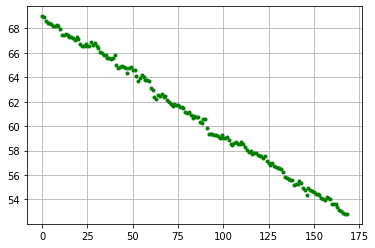

In [26]:
centroids = []
for i in range(result.shape[0]): # Iterate over each row
    j = np.arange(result.shape[1]) # = [0, 1, 2, ..., #num_of_columns-1]
    
    sumx = np.sum(result[i,:]) # Sum over entire row
    if sumx < 1e-4: # Avoid division by zero
        c = 0
    else:
        c = np.sum(j*result[i,:])/sumx # centroid calculation
    
    c -= 0.5 # Minor correction for offset because of derivation
    centroids.append(c)
    
plt.plot(centroids, 'g.')
plt.grid('on')
plt.show()

## Fit line

Do a polynomial 1st degree fitting onto the points.

In [29]:
i = np.arange(len(centroids))
z = np.polyfit(i, centroids, 1)

print(z)

[-0.09641138 68.96586726]


The first return value is the slope and the second the intercept. Plotting the line the line onto the points shows, it indeeds approximate it nicely.

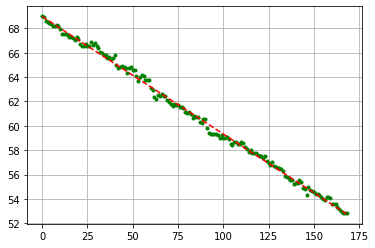

In [35]:
p = np.poly1d(z)

plt.plot(centroids, 'g.')
plt.plot(p(i), 'r--')
plt.grid('on')
plt.show()

The angle $\alpha$ of the slanted edge can be computed easily now with the slope.

$\alpha = atan(-slope)$

In [37]:
import math

print(math.atan(-z[0]) * 180/np.pi) # convert radians to degrees

5.506944373070266


The fitted line can also be superimposed onto the source image.

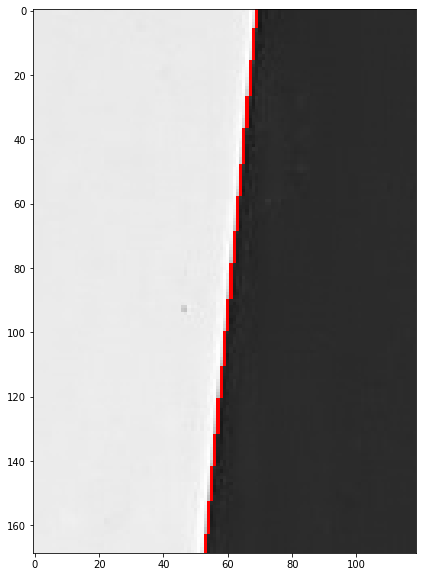

In [40]:
annotated = cv.cvtColor(src[:,:,1], cv.COLOR_GRAY2BGR) # Take green channel and conver it to 3 channel to annotate in color
x0, y0 = p(0), 0 # Line point at the top
x1, y1 = p(src.shape[0]), src.shape[0] # Line point at the bottom

cv.line(annotated, (round(x0), round(y0)), (round(x1), round(y1)), (0, 0, 255), 1)
plt.figure(figsize=(10, 10))
plt.imshow(annotated[:,:,::-1])
plt.show()

## Compute ESF

Now, all the ESF are averaged into one. For this an accumulator is created with two lines. The first will contain the accumulated pixels values and the second the count. To get the average, the first line has be to be divided by the second line.

But this is too simple! srfmat3 had to go more complicated. It uses a supersampling method to slightly improve the resulting ESF more. With the pixels shifted for each row, the x position is a float number. Instead of applying a round/floor/ceil, the float position is kept somewhat by having an accumulator with more cells. 

Here we will use a supersampling of 4x, so a single unit is divided into 4. The accumulator has all to take into account that the pixels in the bottom rows could go outside the frame because of the shifting. The accumulator has to be extended to avoid any out of range error.

Taken all this into account, the accumulator array is created.

In [43]:
fac = 4 # supersampling multiplier
extra = math.ceil(abs(green.shape[0]*z[0])) # Extra to account for pixels that could go outside the frame
bins = np.zeros((2, (green.shape[1] + extra)*fac))

print(green.shape)
print(bins.shape)

(169, 119)
(2, 544)


The pixels of the input image are all processed and put into the accumulator array.

In [44]:
for x in range(green.shape[1]):
    for y in range(green.shape[0]):
        x_off = math.ceil((x - z[0]*y)*fac) # computed shifted x position
        bins[0, x_off] += 1 # count 
        bins[1, x_off] += green[y, x] # pixel value

### Complete the zero accumulator cells

Some cell of the accumulator could be empty. This is problematic so the accumulator value on the left is taken and copied.

In [45]:
for i in range(bins.shape[1]):
    if bins[0, i] == 0: # count is 0
        bins[0, i] = bins[0, i-1]
        bins[1, i] = bins[1, i-1]

Compute the average ESF.

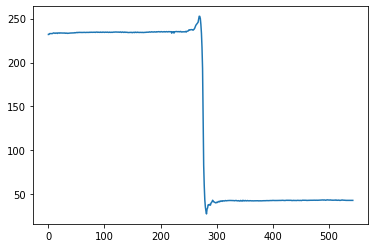

In [46]:
esf = bins[1, :] / bins[0, :]
plt.plot(esf)
plt.show()

## Compute LSF

From the ESF, the LSF is just its derivative. We use the same technique as before with the convolution but with a kernel of 1x3 with $\begin{bmatrix}-0.5  & 0 & 0.5 \end{bmatrix}$. We also have to be careful of the border which gets incorrect values. The value besides them is copied.

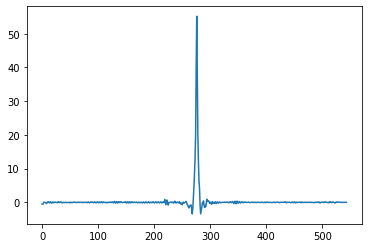

In [48]:
lsf = np.convolve(esf, np.array([-0.5, 0, 0.5]), 'same')
lsf[0] = lsf[1]
lsf[-1] = lsf[-2]

plt.plot(lsf)
plt.show()

Comparing with the LSF of a single row, it looks more refined and precise, so it was worth the effort after all.

Now, before computing the discrete fourier transform. The LSF is centered. The centroid formula is again used to find the center, and the plot is shifted.

In [51]:
j = np.arange(len(lsf))
sumx = np.sum(lsf)
if sumx < 1e-4:
    c = 0
else:
    c = np.sum(j * lsf)/sumx
    
print(f"Center is at {len(lsf)/2}, centroid at {c}")

Center is at 272.0, centroid at 280.4401829620845


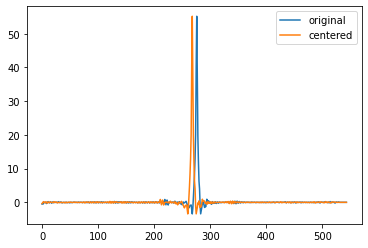

In [55]:
d =  round(c) - len(lsf)//2
centered = np.zeros_like(lsf)
m = len(lsf)

if d > 0: # Shift left
    for i in range(m-d):
        centered[i] = lsf[i + d]
elif d < 1: # Shift right
    for i in range(-d, m):
        centered[i] = lsf[i + d]
else: # Already centered
      centered = lsf

plt.plot(lsf)
plt.plot(centered)
plt.legend(['original', 'centered'])

## Compute MTF

Finally, the LSF or 1D PSF is transformed with an FFT. 

TODO

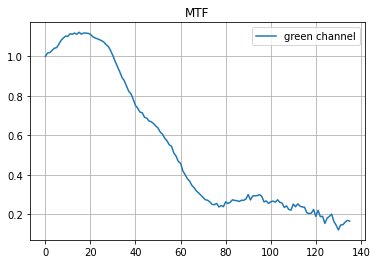

In [58]:
out = np.fft.fft(centered) # Compute FFT
nn2 = math.floor(len(out)/2)+1 # Only half of the frequency domain is useful (symmetric)
freqlim = 1 
nn2out = round(nn2*freqlim/2) # Compute maximum frequency to display
mtf = np.abs(out[:nn2out]) # Compute magnitude
mtf = mtf/mtf[0] # Normalize
plt.plot(mtf)
plt.grid('on')
plt.title('MTF')
plt.legend(['green channel'])
plt.show()